In [1]:
from tensorflow import keras
from keras.datasets import mnist
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from keras.models import Sequential, Model
from keras.layers import Dense
from sklearn.decomposition import PCA
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, LambdaCallback
from sklearn.model_selection import train_test_split


#### Data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
test_morpho = pd.read_csv('t10k-morpho.csv')
train_morpho = pd.read_csv('train-morpho.csv')

#### Helper

##### Modelos 

In [12]:
def modelA():
    K.clear_session()
    earlyStopping = keras.callbacks.EarlyStopping(
        monitor="mae",
        min_delta=0,
        patience=7,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    input_shape = (28, 28, 1) 
    inputs = keras.Input(shape=input_shape)
    flatten = layers.Flatten()(inputs)
    hidden1 = layers.Dense(1000, activation='relu')(flatten)
    dropout = layers.Dropout(0.3)(hidden1)
    hidden2 = layers.Dense(500, activation='relu')(dropout)
    outputs = layers.Dense(1, activation='linear')(hidden2)  
    model_a = keras.Model(inputs=inputs, outputs=outputs)
    model_a.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=0.0001, decay=1E-5), metrics=['mae'])

    model_a.fit(x_train, 
            np.array(train_morpho['slant']),
            epochs=200, batch_size=128, 
            verbose=1, 
            validation_data=(x_test, np.array(test_morpho['slant'])), 
            callbacks=[earlyStopping],
            )

    return model_a

def modelB():
    K.clear_session()
    earlyStopping = keras.callbacks.EarlyStopping(
        monitor="mae",
        min_delta=0,
        patience=7,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    input_shape = (28, 28, 1) 
    Img_input = keras.Input(shape=input_shape)
    Img_flatten = layers.Flatten()(Img_input)
    emb_input = keras.Input(shape=(1,))
    emb_layer = layers.Embedding(10,2)(emb_input)
    emb_flatten = layers.Flatten()(emb_layer)
    sum_of_inputs = layers.Concatenate()([Img_flatten, emb_flatten])

    #A partir de aca uso mismo modelo que A
    hidden1 = layers.Dense(1000, activation='relu')(sum_of_inputs)
    dropout = layers.Dropout(0.3)(hidden1)
    hidden2 = layers.Dense(500, activation='relu')(dropout)
    outputs = layers.Dense(1, activation='linear')(hidden2)  
    model_b = keras.Model(inputs=[Img_input, emb_input], outputs=outputs)
    model_b.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=0.0001, decay=1E-5), metrics=['mae'])

    model_b.fit([x_train,y_train], 
            np.array(train_morpho['slant']),
            epochs=100, batch_size=128, 
            verbose=1, 
            validation_data=([x_test, y_test], np.array(test_morpho['slant'])), 
            callbacks=[earlyStopping],
            )

    return model_b

def modelC(param):
    K.clear_session()
    earlyStopping = keras.callbacks.EarlyStopping(
        monitor="mae",
        min_delta=0,
        patience=7,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    input_shape = (28, 28, 1) 
    Img_input = keras.Input(shape=input_shape)
    Img_flatten = layers.Flatten()(Img_input)

    param_input = keras.Input(shape=(1,))
    param_flatten = layers.Flatten()(param_input)

    sum_of_inputs = layers.Concatenate()([Img_flatten, param_flatten])

    #A partir de aca uso mismo modelo que A
    hidden1 = layers.Dense(1000, activation='relu')(sum_of_inputs)
    dropout = layers.Dropout(0.3)(hidden1)
    hidden2 = layers.Dense(500, activation='relu')(dropout)
    outputs = layers.Dense(1, activation='linear')(hidden2)  
    model_c = keras.Model(inputs=[Img_input, param_input], outputs=outputs)
    model_c.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=0.0001, decay=1E-5), metrics=['mae'])

    model_c.fit([x_train,train_morpho[param]], 
            np.array(train_morpho['slant']),
            epochs=100, batch_size=128, 
            verbose=1, 
            validation_data=([x_test, test_morpho[param]], np.array(test_morpho['slant'])), 
            callbacks=[earlyStopping],
            )

    return model_c

##### Plot functions

In [4]:
def plot_number(x_train, y_train, number, show_label=True, figsize=(10, 5)):
    plt.imshow(x_train[number], cmap='gray')
    if show_label:
        plt.text(0,0,str(y_train[number]), color='w', size=20, verticalalignment="top")
    plt.show()
    
def create_row(x_train, numbers):
    concatenated = x_train[numbers[0]]
    numbers=numbers[1:]
    for n in numbers:
        concatenated = np.concatenate((concatenated, x_train[n]), axis=1)
    return concatenated

def plot_numbers(x_train, numbers, columns=10, show_label=True, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    numbers = np.array(numbers).reshape(-1, columns)
    concatenated = create_row(x_train, numbers[0])
    numbers = numbers[1:,:]
    for row in numbers:
        concatenated = np.concatenate((concatenated, create_row(x_train, row)))
    plt.imshow(concatenated, cmap='gray')
    plt.show()
 
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

#### DataBase

In [5]:
print("MNIST train shape:", x_train.shape)   # (60000, 28, 28)
print("MNIST test shape:", x_test.shape)     # (10000, 28, 28)
print("Morpho train shape:", train_morpho.shape)  # (60000, 7)
print("Morpho test shape:", test_morpho.shape)    # (10000, 7)

MNIST train shape: (60000, 28, 28)
MNIST test shape: (10000, 28, 28)
Morpho train shape: (60000, 7)
Morpho test shape: (10000, 7)


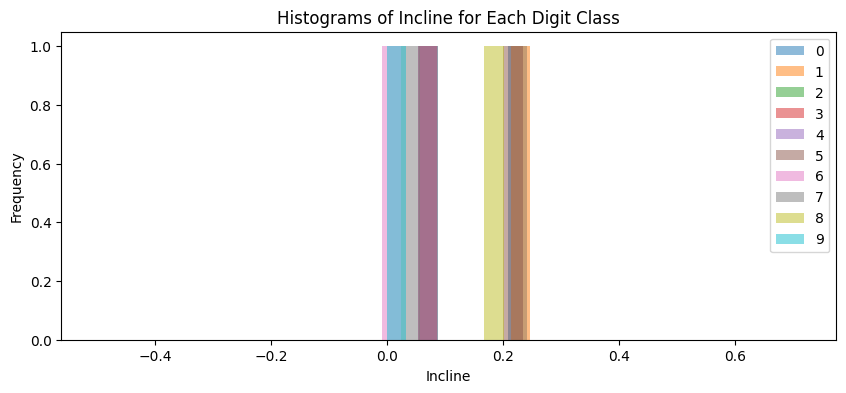

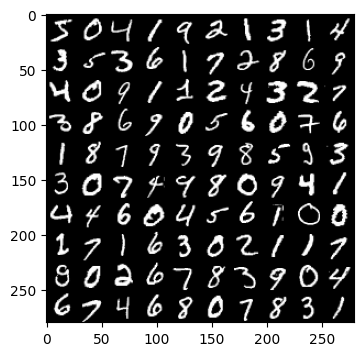

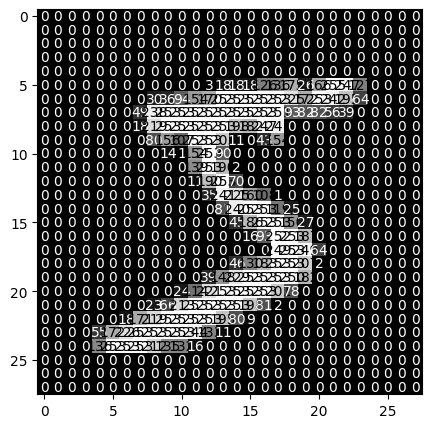

In [6]:
# Agrupar los descriptores morfológicos por clase
morpho_by_class = train_morpho.groupby(y_train)["slant"].mean()

# Histogramas de inclinación para cada clase
plt.figure(figsize=(10, 4))
for digit, incline in morpho_by_class.items():
    plt.hist(incline, bins=30, alpha=0.5, label=str(digit))
plt.xlabel("Incline")
plt.ylabel("Frequency")
plt.title("Histograms of Incline for Each Digit Class")
plt.legend()
plt.show()

plot_numbers(x_train,range(100), columns=10, figsize=(4, 4))
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
visualize_input(x_train[0], ax)
plt.show()

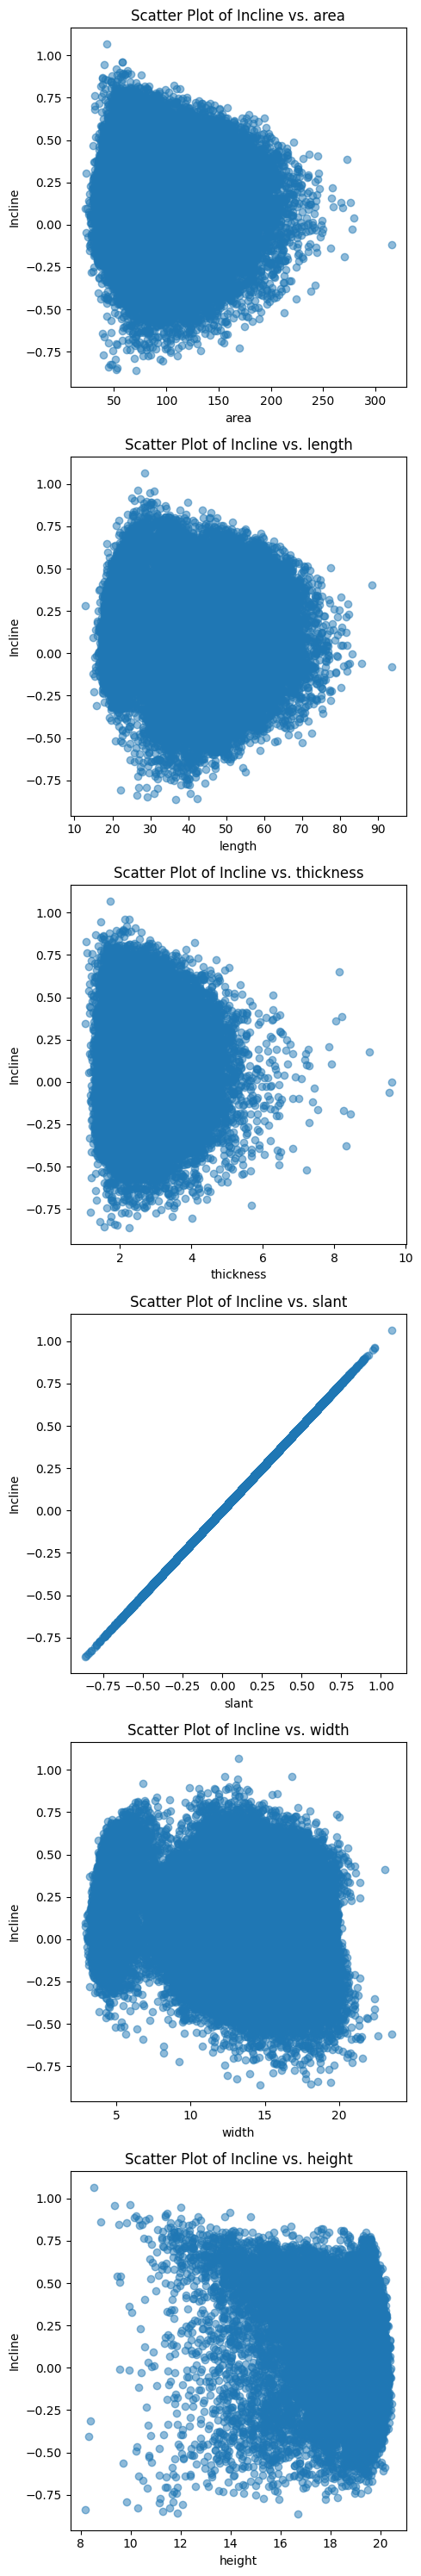

In [7]:
# columnas
morpho_features = ["area", "length", "thickness", "slant", "width", "height"]
colors = ["red", "blue", "green", "orange", "purple", "pink"]
fig, axes = plt.subplots(nrows=len(morpho_features), figsize=(5, 5 * len(morpho_features)))

for i, feature in enumerate(morpho_features):
    ax = axes[i]
    ax.scatter(train_morpho[feature], train_morpho["slant"], alpha=0.5)
    ax.set_xlabel(feature)
    ax.set_ylabel("Incline")
    ax.set_title(f"Scatter Plot of Incline vs. {feature}")

fig.tight_layout()

plt.show()

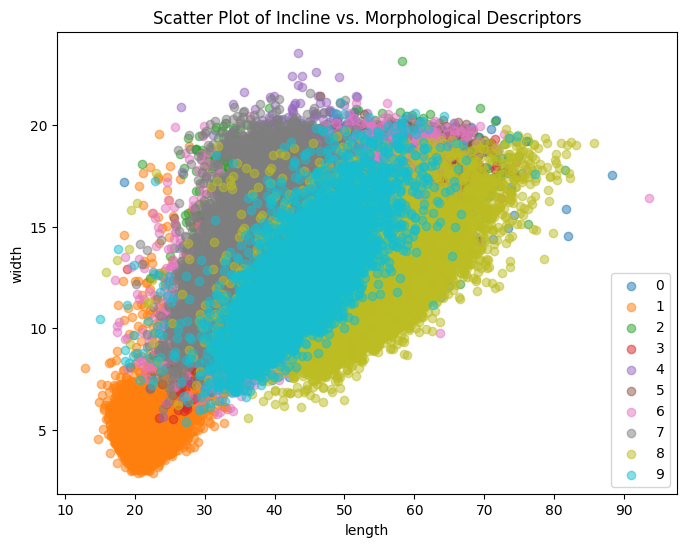

In [8]:
# Selección de descriptores adicionales para el gráfico de dispersión
selected_features = ["length", "width"]

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
for digit, incline in morpho_by_class.items():
    plt.scatter(train_morpho.loc[y_train == digit, selected_features[0]],
                train_morpho.loc[y_train == digit, selected_features[1]],
                alpha=0.5, label=str(digit))
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title("Scatter Plot of Incline vs. Morphological Descriptors")
plt.legend()
plt.show()

#### Modelos

##### Modelo A

In [11]:
model_A = modelA()
model_A.evaluate(x_test, test_morpho['slant'])


Epoch 1/200
469/469 [==============================] - 12s 24ms/step - loss: 526.4929 - mae: 16.3566 - val_loss: 75.2026 - val_mae: 6.9787
Epoch 2/200
469/469 [==============================] - 10s 22ms/step - loss: 93.8677 - mae: 7.6045 - val_loss: 24.5437 - val_mae: 3.9767
Epoch 3/200
469/469 [==============================] - 11s 22ms/step - loss: 41.7117 - mae: 5.0547 - val_loss: 11.5982 - val_mae: 2.7700
Epoch 4/200
469/469 [==============================] - 11s 23ms/step - loss: 19.8948 - mae: 3.4816 - val_loss: 3.7368 - val_mae: 1.5372
Epoch 5/200
469/469 [==============================] - 11s 23ms/step - loss: 9.5739 - mae: 2.3994 - val_loss: 1.3734 - val_mae: 0.9313
Epoch 6/200
469/469 [==============================] - 11s 23ms/step - loss: 4.6131 - mae: 1.6364 - val_loss: 0.4628 - val_mae: 0.5375
Epoch 7/200
469/469 [==============================] - 11s 23ms/step - loss: 2.4616 - mae: 1.1688 - val_loss: 0.2001 - val_mae: 0.3498
Epoch 8/200
469/469 [=========================

[0.002675275318324566, 0.03873109817504883]

##### Modelo B

Epoch 1/100
469/469 [==============================] - 15s 29ms/step - loss: 495.6178 - mae: 15.9971 - val_loss: 77.8922 - val_mae: 7.1642
Epoch 2/100
469/469 [==============================] - 13s 28ms/step - loss: 100.5779 - mae: 7.8740 - val_loss: 23.4179 - val_mae: 3.8333
Epoch 3/100
469/469 [==============================] - 13s 28ms/step - loss: 47.7401 - mae: 5.4290 - val_loss: 11.7345 - val_mae: 2.7253
Epoch 4/100
469/469 [==============================] - 13s 27ms/step - loss: 25.3006 - mae: 3.9513 - val_loss: 6.5372 - val_mae: 2.0208
Epoch 5/100
469/469 [==============================] - 13s 28ms/step - loss: 14.1709 - mae: 2.9296 - val_loss: 2.8702 - val_mae: 1.3435
Epoch 6/100
469/469 [==============================] - 13s 28ms/step - loss: 8.0957 - mae: 2.1996 - val_loss: 1.4253 - val_mae: 0.9469
Epoch 7/100
469/469 [==============================] - 13s 28ms/step - loss: 4.6994 - mae: 1.6634 - val_loss: 0.6837 - val_mae: 0.6480
Epoch 8/100
469/469 [=======================

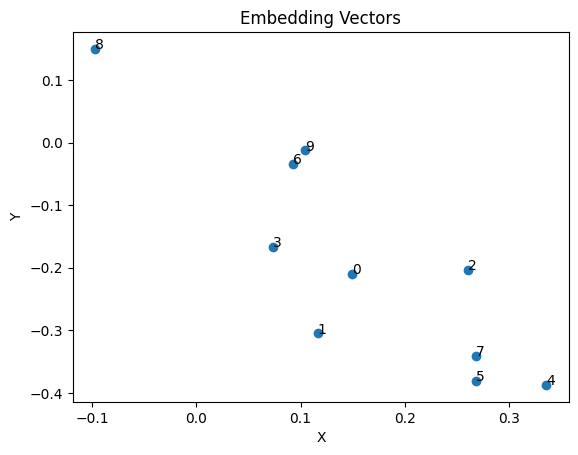

In [13]:
model_B= modelB()
model_B.evaluate([x_test, y_test], test_morpho['slant'])

weights = model_B.layers[2].get_weights()[0]
indices = np.arange(len(weights))

x = [vector[0] for vector in weights]
y = [vector[1] for vector in weights]
plt.scatter(x, y)

for i, index in enumerate(indices):
    plt.annotate(index, (x[i], y[i]))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Embedding Vectors')
plt.show()

##### Modelo C

In [14]:
model_C = modelC('width')
model_C.evaluate([x_test, test_morpho['width']], test_morpho['slant'])

Epoch 1/100
469/469 [==============================] - 11s 23ms/step - loss: 445.0082 - mae: 15.2163 - val_loss: 40.0413 - val_mae: 5.0178
Epoch 2/100
469/469 [==============================] - 11s 23ms/step - loss: 81.2375 - mae: 7.0628 - val_loss: 14.6019 - val_mae: 3.0266
Epoch 3/100
469/469 [==============================] - 11s 23ms/step - loss: 35.3218 - mae: 4.6622 - val_loss: 6.1429 - val_mae: 1.9626
Epoch 4/100
469/469 [==============================] - 11s 23ms/step - loss: 16.5443 - mae: 3.1626 - val_loss: 2.3813 - val_mae: 1.2107
Epoch 5/100
469/469 [==============================] - 11s 23ms/step - loss: 7.8356 - mae: 2.1564 - val_loss: 0.9342 - val_mae: 0.7567
Epoch 6/100
469/469 [==============================] - 11s 23ms/step - loss: 4.0073 - mae: 1.5151 - val_loss: 0.4054 - val_mae: 0.5059
Epoch 7/100
469/469 [==============================] - 11s 24ms/step - loss: 2.0510 - mae: 1.0616 - val_loss: 0.5093 - val_mae: 0.6231
Epoch 8/100
469/469 [==========================

[0.0041342140175402164, 0.048781607300043106]